# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter

CONSUMER_KEY = "wTOj2975uKAhyIyJkrjod2wju"
CONSUMER_SECRET = "v0IpKZ6LxnUN0DgGGAmLE7tgzjiK6u5zMYZnSIFX5ghN8hUoTp"

ACCESS_TOKEN_KEY = "272608335-xS7I2zHOzMQHaI2eSO3RTsPVi8XwOOajXsMxLW1P"
ACCESS_TOKEN_SECRET = "04aF4bmEktxhNv6jpi5QOESYIdLALUAiSmLJgs4h66q6H"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

In [2]:
import pymongo

DATABASE_URL = 'mongodb://donkey:27017/'


client = pymongo.MongoClient(DATABASE_URL)
shpere_db = client.shpere


Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [3]:
import json
def load_twitts(path):
    print "Reading users twitts from %s ..." % path
    with open(path, 'r') as infile:
        twitts = json.load(infile)
        return twitts

twts = load_twitts('files/twitts.json')

Reading users twitts from files/twitts.json ...


In [4]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    user_twts = twts.get("%s" % user_id)
    if not user_twts:
        return []
    data = {
        'lang': 1,
        'favorited': 1,
        'truncated': 1,
        'text': 1,
        'created_at': 1,
        'retweeted': 1,
        'source': 1,
        'user': 1,
        'id': 1,
    }

    user_twts = [{key: value for key, value in twt.items() if key in data}
                                               for twt in user_twts if twt]
    return user_twts

# def get_user_tweets(user_id):
#     """returns list of tweets as dicts"""
#     fields = {
#         'lang': 1,
#         'favorited': 1,
#         'truncated': 1,
#         'text': 1,
#         'created_at': 1,
#         'retweeted': 1,
#         'source': 1,
#         'user': 1,
#         'id': 1,
#         '_id': 0
#     }
#     return list(shpere_db.twitts.find({u"user_id": u"%s" % user_id}, fields))

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [5]:
import re
from nltk.tokenize import TweetTokenizer, RegexpTokenizer


try:
    # Wide UCS-4 build
    emoji_re = re.compile(u'['
        u'\U0001F300-\U0001F64F'
        u'\U0001F680-\U0001F6FF'
        u'\u2600-\u26FF\u2700-\u27BF]+', 
        re.UNICODE)
except re.error:
    # Narrow UCS-2 build
    emoji_re = re.compile(u'('
        u'\ud83c[\udf00-\udfff]|'
        u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
        u'[\u2600-\u26FF\u2700-\u27BF])+', 
        re.UNICODE)


tokenizer = RegexpTokenizer(r'\w+')
tweet_tokenizer = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=False)
hashtag_re = re.compile(r'(#[\w]+)')
url_re = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}     /)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))')
retweet_re = re.compile(r'(RT @(?:\b\w+)+)')
numbers_re = re.compile(r"[ \n\r][-\d.]+[ \n\r!\\\"#$%&'()*+,\-./:;<=>?@[\\\]^_`{|}~]")

def get_words(text):
    """returns list of words"""
#     print repr(text)
    text = url_re.sub('', text)
    
    emojis = emoji_re.findall(text)
    text = emoji_re.sub('', text)
    
    hashtags = hashtag_re.findall(text)
    text = hashtag_re.sub('', text)
    
    retweets = [w.replace(" ", '') for w in retweet_re.findall(text)]
    text = retweet_re.sub('', text)
    
    numbers = numbers_re.findall(text)
    text = numbers_re.sub('', text)
    
    words = [word.lower() for word in tokenizer.tokenize(text)]
    
    return emojis + hashtags + retweets + words

In [6]:
print get_words("Here are different words!")

['here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [7]:
# import nltk
# nltk.download()
# nltk.download("stopwords")

xДля дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [8]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wnl = WordNetLemmatizer()
ss = SnowballStemmer('english')

def get_tokens(words):
    """returns list of tokens"""
#     print words
    
    words = [ss.stem(token) for token in words]
    words = [wnl.lemmatize(token) for token in words]
    
    missed_stopwords = [u"m", u"u", u"wa", u"ha", u"http", u"co", u"t", u"rt"]
    filtered_words = [word for word in words if word not in missed_stopwords + stopwords.words('english')]
#     print filtered_words
#     print "\n"
    return filtered_words

In [9]:
print get_tokens(["here", "are", "different", "words"])

[u'differ', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [10]:
def get_tweet_tokens(tweet):
    words = get_words(tweet)
    return get_tokens(words)

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [11]:
import sys
from collections import Counter

def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    tokens_counters = []
    length = len(df_users.index)

    for i, twitter_id in enumerate(df_users.twitter_id.tolist()):
        sys.stdout.write('\r' + "%s/%s Precessing user_id=%s." % (i, length, twitter_id))
        sys.stdout.flush()

#         tokens = []
#         for tweet in get_user_tweets(twitter_id):
#             tweet_tokens = get_tweet_tokens(tweet.get("text"))
#             tokens += tweet_tokens
#             if u'2012' in tweet_tokens:
#                 print "\n"
#                 print tweet.get("text")
            
        tweets_texts = [tweet.get("text") for tweet in get_user_tweets(twitter_id)]
        merged_text = ' '.join(tweets_texts)
        tokens = get_tweet_tokens(merged_text)

        tokens_counters.append(Counter(tokens))
        
    return df_users.twitter_id.tolist(), tokens_counters

In [12]:
import json
import pandas as pd

from collections import defaultdict
from sklearn.feature_extraction import DictVectorizer

TRAINING_SET_URL = "../hw1/twitter_train.csv"


df_users = pd.read_csv(TRAINING_SET_URL, sep=",")
users, users_tokens = collect_users_tokens(df_users)

2999/3000 Precessing user_id=237188227.

In [13]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

Сохраним полученные данные в файл. Используется метод savez из numpy. 

In [14]:
import numpy as np
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [31]:
features_counts = np.asarray(vs.astype(int).sum(axis=0)).ravel()

In [32]:
from collections import Counter

def get_word_counter(a, b):
    return Counter({a[i]:b[i] for i in range(len(a))})

In [33]:
word_counter = get_word_counter(v.feature_names_, features_counts)

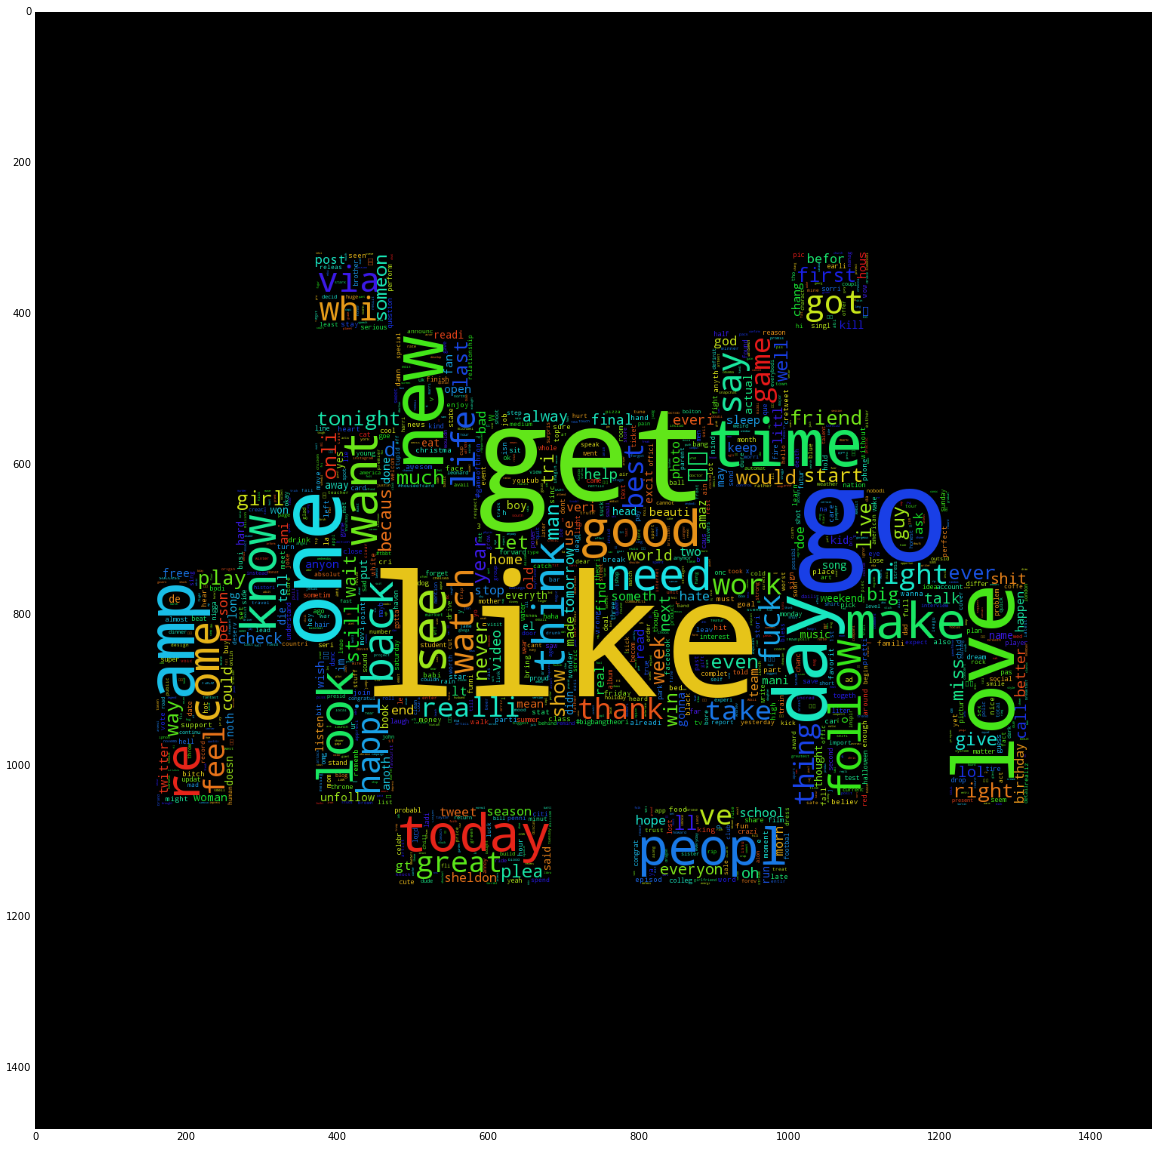

In [30]:
from scipy.misc import imread

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

def draw_tag_cloud(words_frequencies):
    mask = np.invert(imread('./files/invader.png', flatten=True).astype(np.bool)).astype(np.uint) * 255


    wordcloud_params = {
        "font_path": None,
        "width": 1500,
        "height": 1200,
        "margin": 2,
        "ranks_only": False,
        "prefer_horizontal": 0.5,
        "mask": mask,
        "scale": 1,
        "max_words": 200,
        "min_font_size": 4,
        "stopwords": [u'm'],
        "random_state": None,
#         "background_color": 'gray',
        "max_font_size": None,
        "font_step": 1,
        "mode": "RGBA"
    }
    wc = WordCloud(**wordcloud_params).fit_words(words_frequencies)
    
    wc.to_file("files/words_cloud.png")
    
    plt.figure(figsize=(20, 20))
    plt.imshow(wc)


draw_tag_cloud(word_counter.most_common())